# Exploramos Datos Reservas

_Importación de librerias_

In [268]:
import os
import pandas as pd
from scipy import stats
import tfm_helpers as tfm

pd.set_option("display.max_columns", None)

_Definiciones de ficheros_
* Hoteles

In [269]:
hoteles = ["02", "04", "05", "15", "16", "21", "22"]

data_path = r"data\processed"

_Carga de Datos_

* Reservas

In [270]:
all_reservas = pd.DataFrame()
for hotel in hoteles: 
    file = tfm.getPathToCleanedHistoricalReservasHotel(data_path, hotel, "parquet")

    current_data = pd.read_parquet(file).set_index("Id Reserva")
    all_reservas = pd.concat([all_reservas, current_data])

Comrpobamos los tipos de datos

In [271]:
all_reservas.dtypes

Hotel                                 object
Fecha venta                   datetime64[ns]
Cliente                               object
TTOO                                  object
Agencia                               object
Fecha entrada                 datetime64[ns]
Fecha salida                  datetime64[ns]
Noches                                 int32
Nacionalidad                          object
Régimen factura                       object
Cantidad habitaciones                  int32
AD                                     int64
JR                                     int64
NI                                     int64
CU                                     int64
Tipo facturación estancia             object
Estado reserva                        object
Desglosada                             int32
Usuario venta                         object
Fecha Borrado                 datetime64[ns]
Usuario Borrado                       object
Day Use                                int32
Grupo     

Revisamos el número de noches por estancia, para ver si tenemos datos anómalos

In [272]:
all_reservas["Noches"].describe()

count    486351.000000
mean          7.414526
std           5.709967
min           0.000000
25%           7.000000
50%           7.000000
75%           9.000000
max        2406.000000
Name: Noches, dtype: float64

paraces ser que si tenemos algunas reservas con una duración fuera de lo normal en hoteles de temporada

In [273]:
filtro_reservas_demasiado_largas = (all_reservas["Noches"] > 250)
all_reservas[filtro_reservas_demasiado_largas]


,Hotel,Fecha venta,Cliente,TTOO,Agencia,Fecha entrada,Fecha salida,Noches,Nacionalidad,Régimen factura,Cantidad habitaciones,AD,JR,NI,CU,Tipo facturación estancia,Estado reserva,Desglosada,Usuario venta,Fecha Borrado,Usuario Borrado,Day Use,Grupo,Master del grupo,Canal_Origen,Segmento,Régimen uso,Canal_Origen Aux,Id Tipo habitacion uso,Id Tipo habitacion factura
Id Reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02-2011-1126R-1,02,2011-01-01,429,REWE TOURISTIK,MTS INCOMING,2011-06-13,2018-01-13,2406,DE,AL,1,3,0,0,0,Agencia,Anulada,1,02JEFEREC,2011-03-21,02JEFEREC,0,None,0,None,None,AL,None,02-A,02-A
16-2010-4692-1,16,2010-07-27,158,FLY,ULTRAMAR EXPRESS S.A,2010-08-29,2015-12-06,1925,DE,AI,1,2,2,0,0,Agencia,Anulada,1,HILDECB,2010-08-02,AGUSTINASA,0,None,0,None,None,AI,None,16-A,16-A


En este caso como las reservas estan Anuladas y los hoteles son de temporada, nos inclinamos por eliminar estas reservas del conjunto, pues probablemente se deben a errores de usuario en la introducción de las reservas.

Por lo que vemos en los códigos de los usuarios que introducen y anulan las reservas no pertenecen a procesos automatizados.

In [274]:
all_reservas_clean = all_reservas.drop(index=all_reservas[filtro_reservas_demasiado_largas].index)
all_reservas_clean["Noches"].describe()

count    486349.000000
mean          7.405651
std           3.635060
min           0.000000
25%           7.000000
50%           7.000000
75%           9.000000
max         219.000000
Name: Noches, dtype: float64

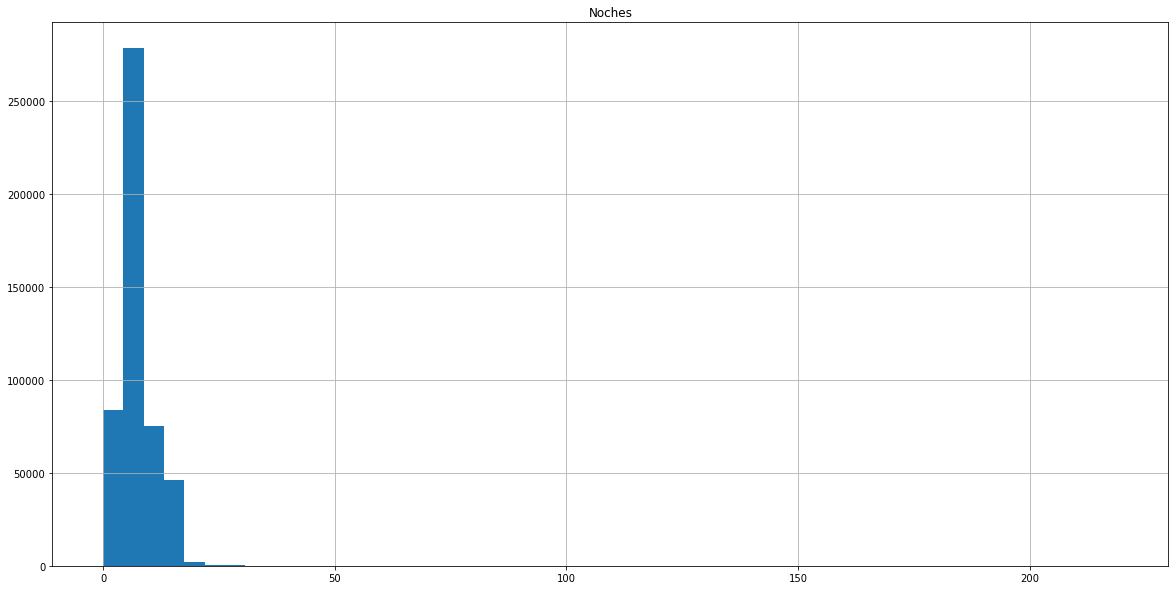

In [275]:
all_reservas_clean.hist(column="Noches", bins=50, figsize=(20, 10));

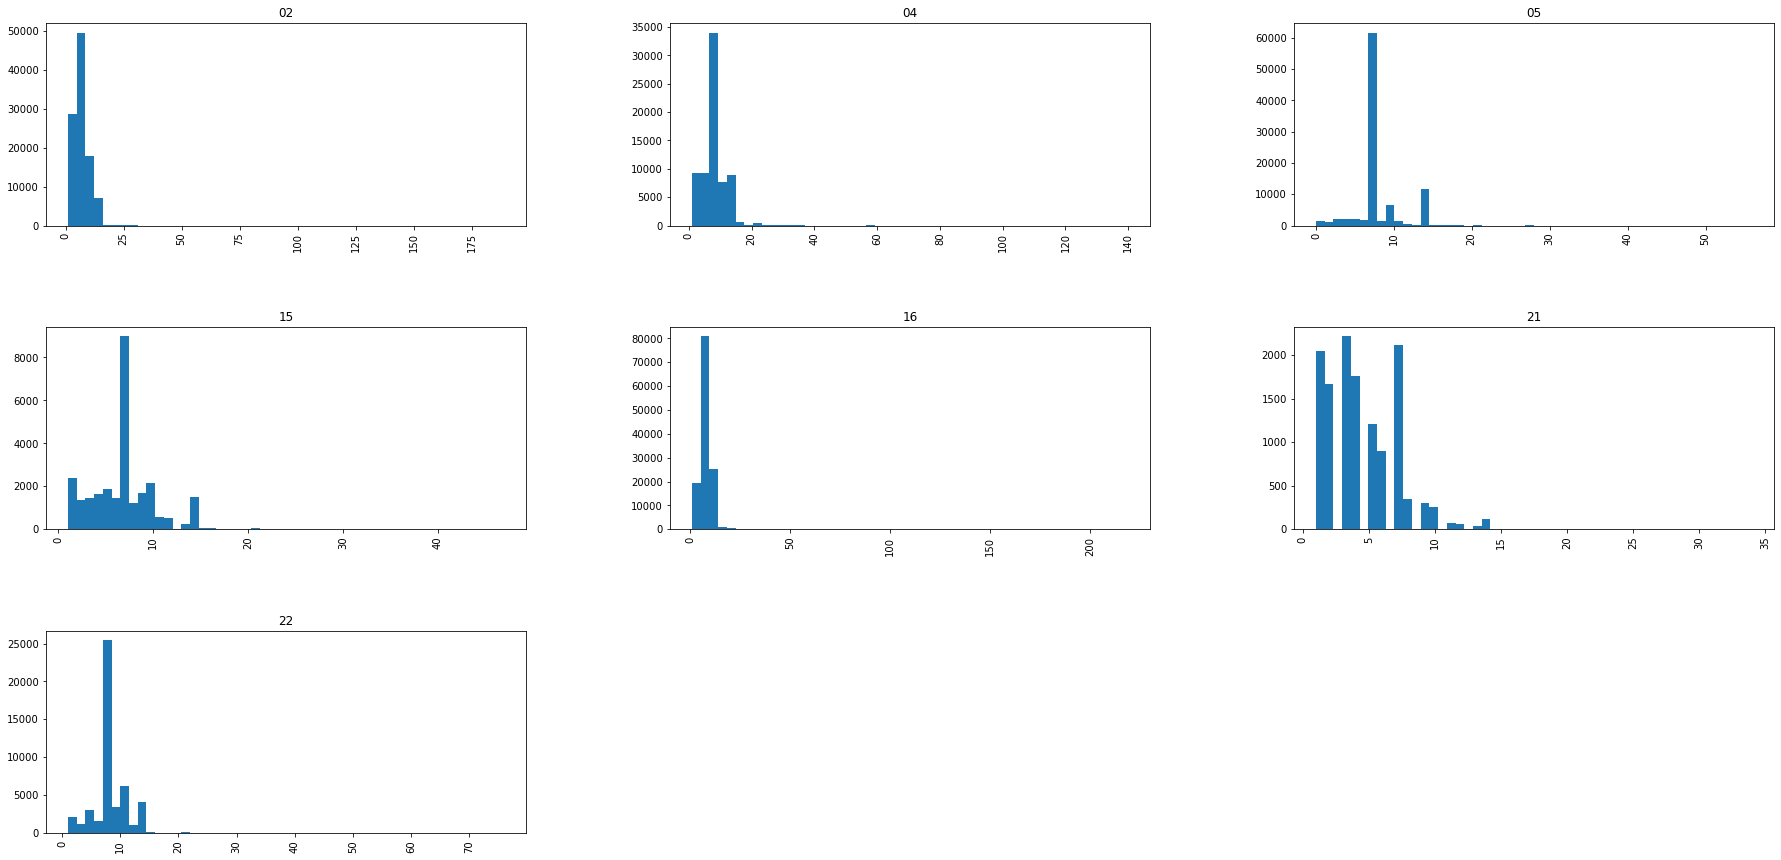

In [276]:
all_reservas_clean.hist(by="Hotel", column="Noches", bins=50, figsize=(30, 15));

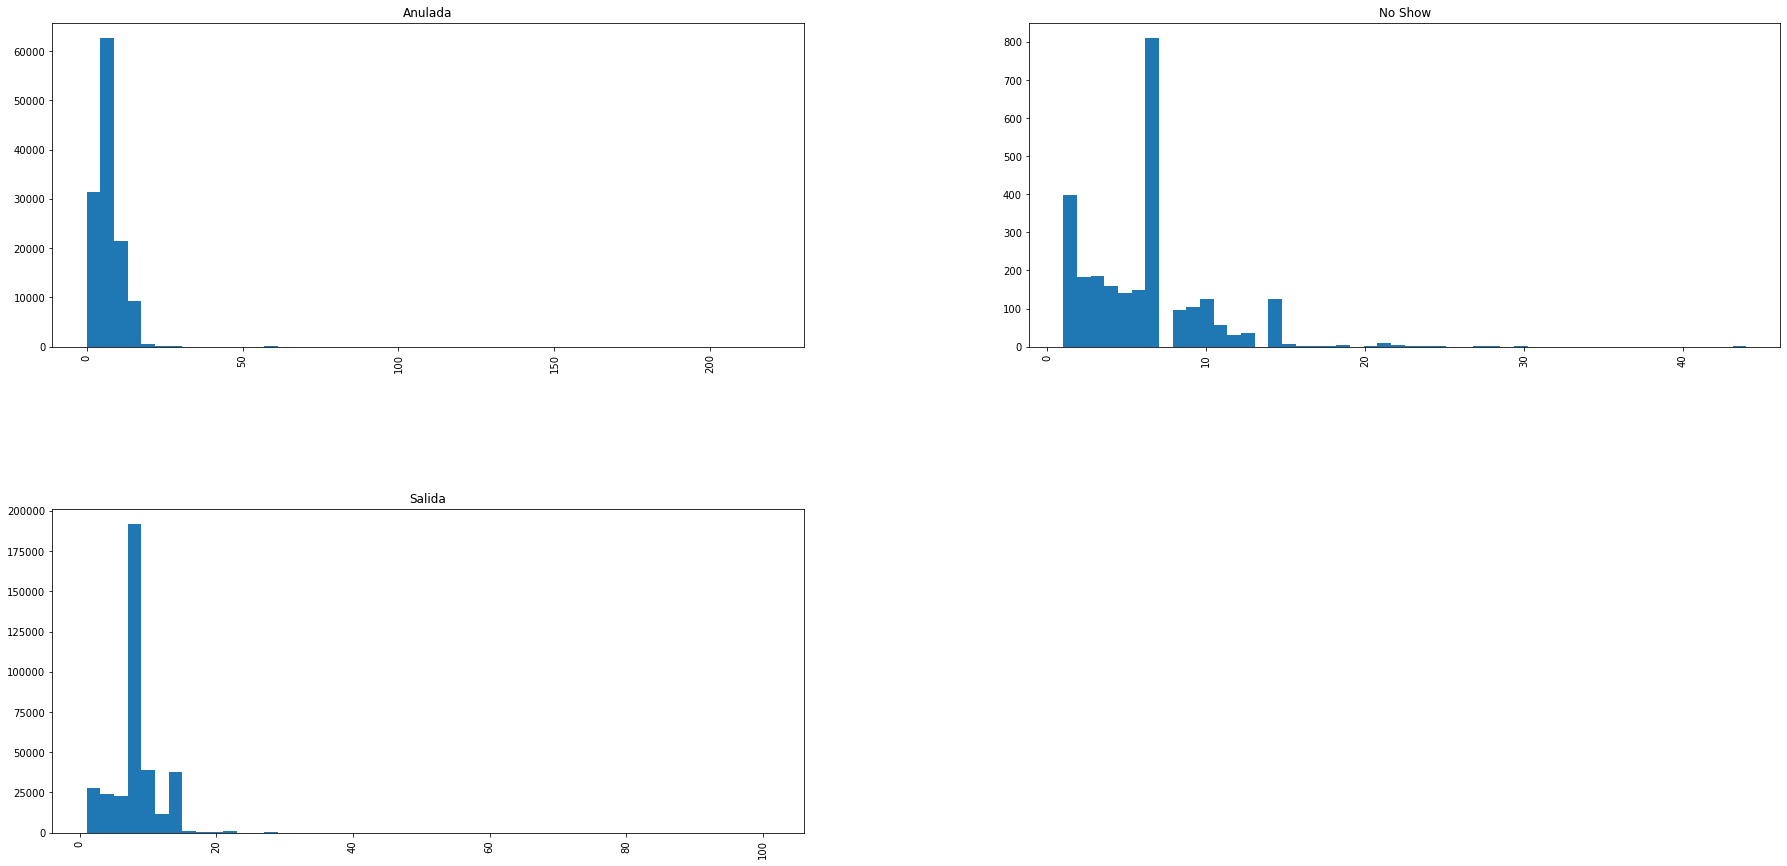

In [277]:
all_reservas_clean.hist(by="Estado reserva", column="Noches", bins=50, figsize=(30, 15));

Revisamos en detalle la Fecha de Venta

In [278]:
primera_fecha_venta = all_reservas_clean["Fecha venta"].min()
ultima_fecha_venta =  all_reservas_clean["Fecha venta"].max()
print(f"La fecha de venta más antigua es {primera_fecha_venta} y la más actual {ultima_fecha_venta}")

La fecha de venta más antigua es 1753-01-01 00:00:00 y la más actual 2022-01-05 00:00:00


In [279]:
all_reservas_clean["Fecha venta"].describe(datetime_is_numeric=True)

count                           486349
mean     2015-07-08 21:22:31.318497280
min                1753-01-01 00:00:00
25%                2013-03-16 00:00:00
50%                2016-04-18 00:00:00
75%                2018-06-07 00:00:00
max                2022-01-05 00:00:00
Name: Fecha venta, dtype: object

Vemos que tenemos valores anómalos (como fechas vacías tipo 1753-01-01) que pueden afectar a nuestros cálculos. Revisando los datos, vemos que estas fechas pertenecen a reservas en estado de reserva "Salida" creemos que es mejor correjir estos valores.

Años atrás, las reservas se introducían manualmente en el sistema y algunas veces si no se disponia de la fecha de venta real y en el bono de la reserva se indicaba que estaba bonificada con algun tipo de "Early Booking" se introducian fechas a medida para que se cumpliese ese Early Booking.

Por lo tanto, creo que lo mejor es ajustar esas fechas de venta a la media truncada de todas las reservas, para que afecte lo menos posible al cálculo de anticipación de venta y ocupación.

 Los días de Anticipación de Compra

In [280]:
all_reservas_clean[["Fecha venta", "Fecha entrada"]].describe(datetime_is_numeric=True)

,Fecha venta,Fecha entrada
count,486349,486349
mean,2015-07-08 21:22:31.318497280,2015-10-26 08:23:31.549319424
min,1753-01-01 00:00:00,2006-02-10 00:00:00
25%,2013-03-16 00:00:00,2013-07-13 00:00:00
50%,2016-04-18 00:00:00,2016-08-17 00:00:00
75%,2018-06-07 00:00:00,2018-08-31 00:00:00
max,2022-01-05 00:00:00,2022-01-11 00:00:00


In [281]:
(all_reservas_clean["Fecha entrada"] - all_reservas_clean["Fecha venta"]).dt.days.describe()

count    486349.000000
mean        109.459030
std         289.586708
min       -3468.000000
25%          24.000000
50%          82.000000
75%         171.000000
max       94708.000000
dtype: float64

Segun el valor de min, parece ser que hay reservas con la fecha de entrada inferior a la fecha de venta. Por lo que antes de calcular la media truncado, primero revisaremos estos valores

In [282]:
filtro_fecha_venta_mayor_fecha_entrada = (all_reservas_clean["Fecha entrada"] < all_reservas_clean["Fecha venta"])
all_reservas_clean[filtro_fecha_venta_mayor_fecha_entrada]

,Hotel,Fecha venta,Cliente,TTOO,Agencia,Fecha entrada,Fecha salida,Noches,Nacionalidad,Régimen factura,Cantidad habitaciones,AD,JR,NI,CU,Tipo facturación estancia,Estado reserva,Desglosada,Usuario venta,Fecha Borrado,Usuario Borrado,Day Use,Grupo,Master del grupo,Canal_Origen,Segmento,Régimen uso,Canal_Origen Aux,Id Tipo habitacion uso,Id Tipo habitacion factura
Id Reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02-2013-3228-1,02,2013-05-08,45,THOMAS COOK NE,THOMAS COOK NE,2013-05-07,2013-05-14,7,SE,AL,1,2,0,0,0,Agencia,Salida,1,02CONSERJE,1753-01-01,None,0,None,0,None,None,AL,None,02-A,02-A
02-2013-4574-1,02,2013-05-29,5041,HOTELS4U.COM,HOTELS4U.COM,2013-05-28,2013-06-04,7,None,AI,1,2,0,2,0,Agencia,Salida,1,02CONSERJE,1753-01-01,None,0,None,0,None,None,AI,None,02-A,02-A
02-2013-4591-1,02,2013-08-27,45,THOMAS COOK NE,THOMAS COOK NE,2013-08-03,2013-08-10,7,SE,AL,1,2,1,1,0,Agencia,Anulada,1,MARIAMBP,2013-07-26,JUANAABC,0,None,0,None,None,AL,None,02-A,02-A
02-2013-3412-1,02,2013-12-12,158,TUI,ULTRAMAR EXPRESS S.A,2013-08-27,2013-09-10,14,DE,AD,1,2,0,0,0,Agencia,Anulada,1,SAMANTHAKSR,2013-05-14,SAMANTHAKSR,0,None,0,None,None,AD,None,02-SM,02-SM
02-2014-5077-1,02,2014-06-04,9028,BOOKINGS.COM,DIR COMISIONABLE,2014-06-03,2014-06-11,8,None,AL,1,2,0,1,1,Directo,Salida,1,02CONSERJE,1753-01-01,None,0,None,0,None,None,AL,None,02-A,02-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22-2018-1595-3,22,2018-10-09,5174,BRAVO TOURS,VIAJES LEOMAR,2018-06-11,2018-06-18,7,DE,AI,1,1,0,0,0,Agencia,Anulada,1,VIVA\FRANCISCACL,2018-02-26,VIVA\FRANCISCACL,0,None,0,None,None,AI,None,22-S,22-S
22-2018-2138-1,22,2018-10-31,5174,BRAVO TOURS,VIAJES LEOMAR,2018-06-16,2018-06-23,7,DE,AI,1,2,1,0,0,Agencia,Anulada,1,VIVA\FRANCISCACL,2018-03-29,VIVA\JOLANTAL,0,None,0,None,None,AI,None,22-A,22-A
22-2018-6144-1,22,2018-10-10,51,DESPLAZADOS,CMRESORT,2018-10-09,2018-10-10,1,None,AI,1,2,0,1,0,Agencia,Salida,1,VIVA\MARGARITATR,1753-01-01,None,0,None,0,None,None,AI,None,22-AP,22-A


En este caso, parece ser que la mayoría de las reservas se han introducido en el sistema el dia siguiente a la entrada, lo que tal vez indica que son reservas de último minuto por lo tanto en este caso, optaremos por igualar la fecha de venta a la fecha de entrada

In [283]:
all_reservas_clean.loc[filtro_fecha_venta_mayor_fecha_entrada, "Fecha venta"] = all_reservas_clean["Fecha entrada"]

Volvemos a comprobar los datos y vemos que ya no ha y ninguna fecha de venta mayor a la fecha de entrada

In [284]:
filtro_fecha_venta_mayor_fecha_entrada = (all_reservas_clean["Fecha entrada"] < all_reservas_clean["Fecha venta"])
all_reservas_clean[filtro_fecha_venta_mayor_fecha_entrada]

,Hotel,Fecha venta,Cliente,TTOO,Agencia,Fecha entrada,Fecha salida,Noches,Nacionalidad,Régimen factura,Cantidad habitaciones,AD,JR,NI,CU,Tipo facturación estancia,Estado reserva,Desglosada,Usuario venta,Fecha Borrado,Usuario Borrado,Day Use,Grupo,Master del grupo,Canal_Origen,Segmento,Régimen uso,Canal_Origen Aux,Id Tipo habitacion uso,Id Tipo habitacion factura
Id Reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [285]:
all_reservas_clean[["Fecha venta", "Fecha entrada"]].describe(datetime_is_numeric=True)

,Fecha venta,Fecha entrada
count,486349,486349
mean,2015-07-08 18:36:40.064562688,2015-10-26 08:23:31.549319424
min,1753-01-01 00:00:00,2006-02-10 00:00:00
25%,2013-03-16 00:00:00,2013-07-13 00:00:00
50%,2016-04-18 00:00:00,2016-08-17 00:00:00
75%,2018-06-07 00:00:00,2018-08-31 00:00:00
max,2022-01-05 00:00:00,2022-01-11 00:00:00


In [286]:
(all_reservas_clean["Fecha entrada"] - all_reservas_clean["Fecha venta"]).dt.days.describe()

count    486349.000000
mean        109.574207
std         289.468227
min           0.000000
25%          24.000000
50%          82.000000
75%         171.000000
max       94708.000000
dtype: float64

Ya podemos calcular la media truncada de los días de anticipación de venta de una reserva, y con este valor calcular la fecha de venta de aquellas reservas anómalas.

In [287]:
media_truncada_dias_anticipacion = int(stats.trim_mean(((all_reservas["Fecha entrada"] - all_reservas["Fecha venta"]).dt.days), 0.1))
print(media_truncada_dias_anticipacion)

95


Añadimos dias de anticipación diferencia entre "Fecha Entrada" y Fecha "Venta"

In [288]:
all_reservas_clean["Días Anticipación"] = (all_reservas_clean["Fecha entrada"] - all_reservas_clean["Fecha venta"]).dt.days

all_reservas_clean.head(10)

,Hotel,Fecha venta,Cliente,TTOO,Agencia,Fecha entrada,Fecha salida,Noches,Nacionalidad,Régimen factura,Cantidad habitaciones,AD,JR,NI,CU,Tipo facturación estancia,Estado reserva,Desglosada,Usuario venta,Fecha Borrado,Usuario Borrado,Day Use,Grupo,Master del grupo,Canal_Origen,Segmento,Régimen uso,Canal_Origen Aux,Id Tipo habitacion uso,Id Tipo habitacion factura,Días Anticipación
Id Reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02-2013-2784-1,02,2013-04-17,9028,DIRECTOS,DIRECTOS,2013-04-17,2013-04-18,1,None,AL,1,1,0,0,0,Directo,Anulada,1,TOMEUSC,2013-04-18,02JEFEREC,0,None,0,None,None,AL,None,02-A,02-A,0
02-2013-2807-1,02,2013-04-19,367,CUENTA CASA,CUENTA CASA,2013-04-20,2013-04-21,1,ES,AI,1,2,0,1,0,Directo,Anulada,1,ZENNIS,2013-04-20,MARIAMBP,0,None,0,None,None,AI,None,02-RS,02-RS,1
02-2013-2565-1,02,2013-04-08,367,CUENTA CASA,CUENTA CASA,2013-04-19,2013-04-21,2,ES,AI,1,2,2,0,0,Directo,Salida,1,02JEFEREC,1753-01-01,None,0,None,0,None,None,AI,None,02-RS,02-A,11
02-2013-2596-1,02,2013-04-11,9028,DIRECTOS,DIRECTOS,2013-04-19,2013-04-21,2,None,AI,1,2,0,1,0,Directo,Salida,1,BARBARAMRM,1753-01-01,None,0,None,0,None,None,AI,None,02-RS,02-A,8
02-2013-2646-1,02,2013-04-13,5041,HOTELS4U.COM,JUMBO TOURS,2013-04-19,2013-04-22,3,None,MPP,1,2,1,0,0,Agencia,Salida,1,NAS,1753-01-01,None,0,None,0,None,None,MPP,None,02-SCA,02-A,6
02-2013-2458-1,02,2013-04-08,785,EXPEDIA.COM,TARJETA AGENCIAS,2013-04-19,2013-04-23,4,None,AL,1,2,0,0,0,Agencia,Anulada,1,NAS,2013-04-19,BARBARAMRM,0,None,0,None,None,AL,None,02-SCA,02-S,11
02-2013-2804-1,02,2013-04-18,785,EXPEDIA.COM,TARJETA AGENCIAS,2013-04-19,2013-04-23,4,None,AL,1,2,0,0,0,Agencia,Salida,1,NAS,1753-01-01,None,0,None,0,None,None,AL,None,02-SCA,02-S,1
02-2013-88-1,02,2012-11-07,5094,ORBITZ.COM,TARJETA AGENCIAS,2013-04-20,2013-04-25,5,None,AL,1,2,0,0,0,Agencia,Salida,1,NAS,1753-01-01,None,0,None,0,None,None,AL,None,02-A,02-S,164
02-2013-89-1,02,2012-11-07,5094,ORBITZ.COM,TARJETA AGENCIAS,2013-04-20,2013-04-25,5,None,AL,1,3,0,0,0,Agencia,Salida,1,NAS,1753-01-01,None,0,None,0,None,None,AL,None,02-A,02-A,164


Debido a la situación del COVID-19 sólo ajustaremos aquellas reservas con fecha de entrada inferior a 2020, ya que durante este periodo muchas reservas se han modificado debido a las restricciones de viaje.

In [327]:
filtro_fecha_venta_anomala = ((all_reservas_clean["Días Anticipación"] > 730) & (all_reservas_clean["Fecha entrada"] < "2020-01-01")) | ((all_reservas_clean["Días Anticipación"] > 1000) & (all_reservas_clean["Fecha entrada"] >= "2020-01-01"))
all_reservas_clean[filtro_fecha_venta_anomala]

,Hotel,Fecha venta,Cliente,TTOO,Agencia,Fecha entrada,Fecha salida,Noches,Nacionalidad,Régimen factura,Cantidad habitaciones,AD,JR,NI,CU,Tipo facturación estancia,Estado reserva,Desglosada,Usuario venta,Fecha Borrado,Usuario Borrado,Day Use,Grupo,Master del grupo,Canal_Origen,Segmento,Régimen uso,Canal_Origen Aux,Id Tipo habitacion uso,Id Tipo habitacion factura,Días Anticipación
Id Reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
04-2020-33-1,04,2009-01-01,429,DER TOURISTIK,DTS,2020-03-10,2020-03-28,18,DE,MP,1,2,0,0,0,Agencia,Anulada,1,VIVA\JEFEREC04,2019-08-07,VIVA\JEFEREC04,0,None,0,None,None,MP,None,04-PREJRS,04-PREJRS,4086
04-2021-1319-1,04,2006-01-01,9028,DIRECTOS,DIRECTOS,2021-06-20,2021-06-24,4,ES,MP,1,2,0,0,0,Directo,Salida,1,VIVA\JEFEREC04,1753-01-01,None,0,None,0,None,None,MP,None,04-PREA,04-SC,5649
22-2021-2113-1,22,2011-06-04,5565,BRAVO TOURS A/S,VIAJES LEOMAR,2021-07-10,2021-07-17,7,DK,AI,1,3,1,0,0,Agencia,Salida,1,VIVA\MIGUELBF,1753-01-01,None,0,None,0,None,None,AI,None,22-AP,22-AP,3689


In [328]:
all_reservas_clean.loc[filtro_fecha_venta_anomala, "Fecha venta"] = all_reservas_clean["Fecha entrada"] - pd.DateOffset(days = media_truncada_dias_anticipacion)

all_reservas_clean["Días Anticipación"] = (all_reservas_clean["Fecha entrada"] - all_reservas_clean["Fecha venta"]).dt.days

Volvemos a revisar las fechas de venta

In [329]:
filtro_fecha_venta_anomala = (all_reservas_clean["Días Anticipación"] > 730) & (all_reservas_clean["Fecha entrada"] < "2020-01-01")
all_reservas_clean[filtro_fecha_venta_anomala]

,Hotel,Fecha venta,Cliente,TTOO,Agencia,Fecha entrada,Fecha salida,Noches,Nacionalidad,Régimen factura,Cantidad habitaciones,AD,JR,NI,CU,Tipo facturación estancia,Estado reserva,Desglosada,Usuario venta,Fecha Borrado,Usuario Borrado,Day Use,Grupo,Master del grupo,Canal_Origen,Segmento,Régimen uso,Canal_Origen Aux,Id Tipo habitacion uso,Id Tipo habitacion factura,Días Anticipación
Id Reserva,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [333]:
primera_fecha_venta = all_reservas_clean["Fecha venta"].min()
ultima_fecha_venta =  all_reservas_clean["Fecha venta"].max()
print(f"La fecha de venta más antigua es {primera_fecha_venta} y la más actual {ultima_fecha_venta}")
primera_fecha_entrada = all_reservas_clean["Fecha entrada"].min()
ultima_fecha_entrada =  all_reservas_clean["Fecha entrada"].max()
print(f"La fecha de entrada más antigua es {primera_fecha_entrada} y la más actual {ultima_fecha_entrada}")

all_reservas_clean["Días Anticipación"].describe()

La fecha de venta más antigua es 2005-07-26 00:00:00 y la más actual 2022-01-05 00:00:00
La fecha de entrada más antigua es 2006-02-10 00:00:00 y la más actual 2022-01-11 00:00:00


count    486349.000000
mean        108.361531
std          99.413502
min           0.000000
25%          24.000000
50%          82.000000
75%         171.000000
max         915.000000
Name: Días Anticipación, dtype: float64

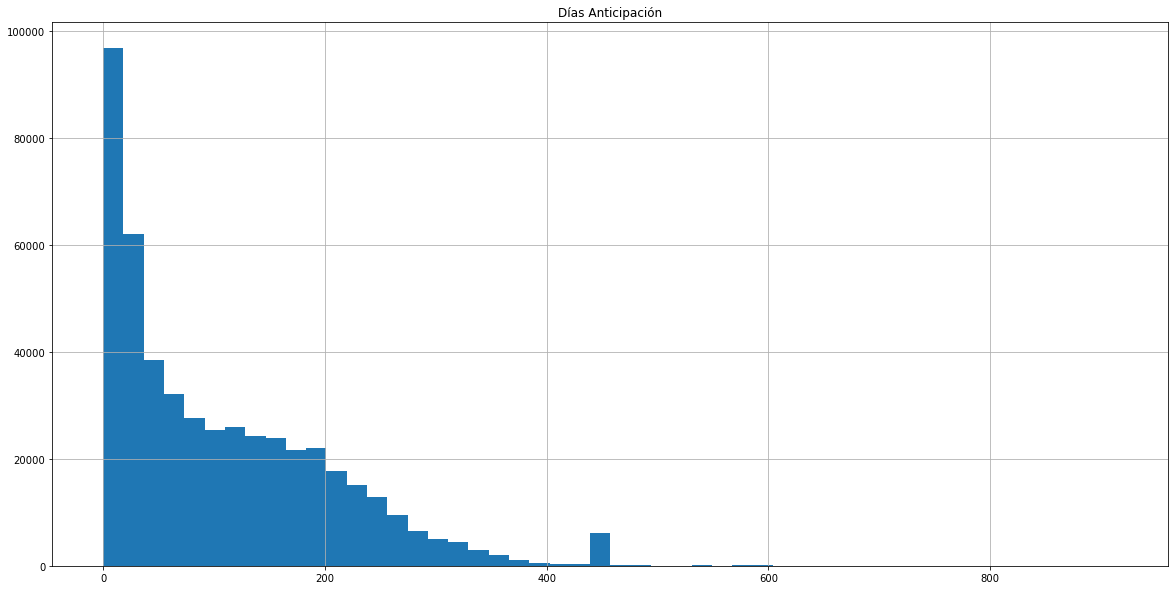

In [340]:
all_reservas_clean.hist(column="Días Anticipación", bins=50, figsize=(20, 10));

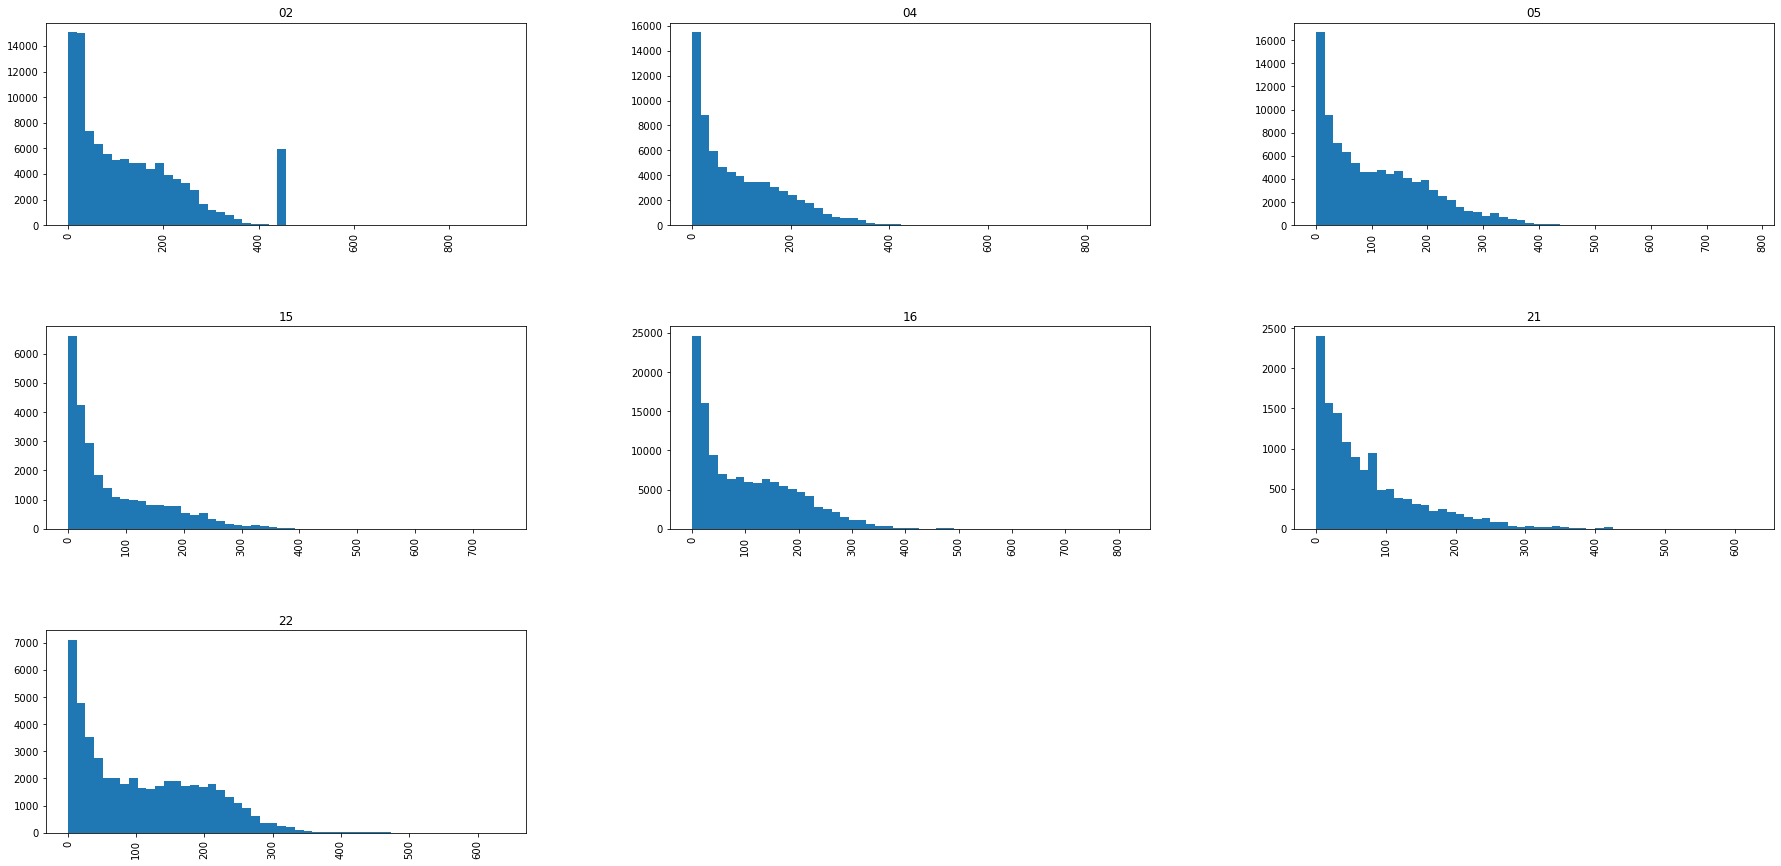

In [341]:
all_reservas_clean.hist(by="Hotel", column="Días Anticipación", bins=50, figsize=(30, 15));


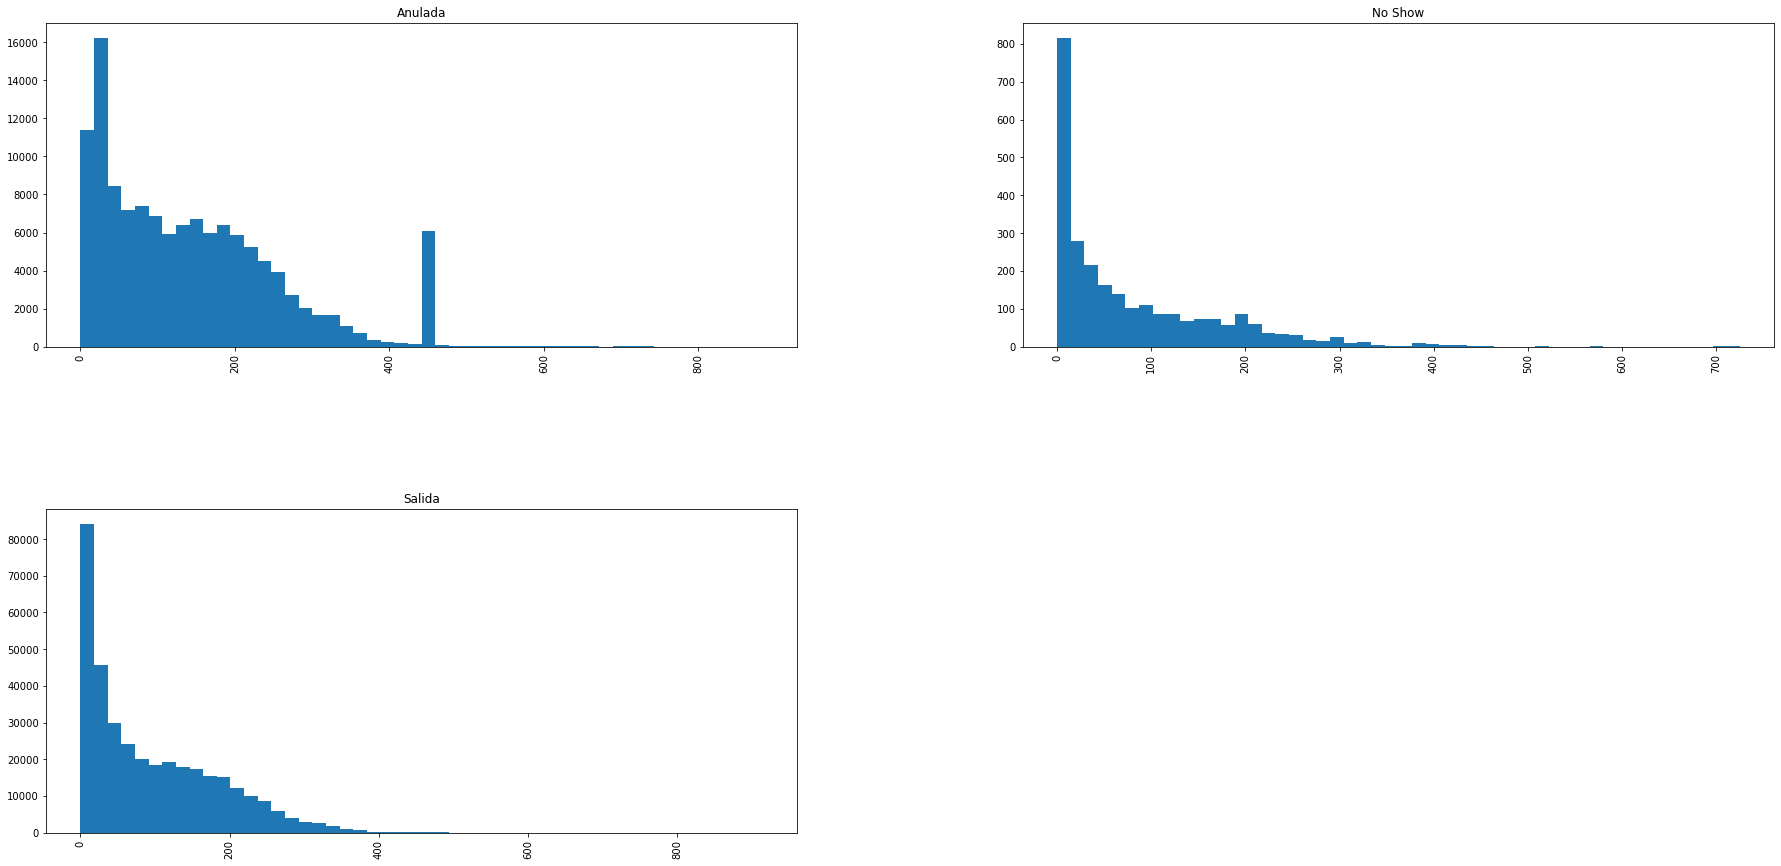

In [342]:
all_reservas_clean.hist(by="Estado reserva", column="Días Anticipación", bins=50, figsize=(30, 15));